<a href="https://colab.research.google.com/github/yoyocookie/airbnb_analysis/blob/main/airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data from Kaggle API


In [1]:
from IPython.core.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# !pip uninstall catboost
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import dcg_score
from sklearn.impute import KNNImputer
os.getcwd()


'/content'

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
  .CodeMirror pre {
    font-family: 'Courier New', monospace !important;
    font-size: 16px !important;
  }
</style>
""")


In [ ]:
#上傳 .json檔
# from google.colab import files
# files.upload()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# 將檔案存放於 /MyDrive/kaggle/kaggle.json
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

 77% 50.0M/64.7M [00:00<00:00, 87.7MB/s]
100% 64.7M/64.7M [00:00<00:00, 101MB/s] 


In [6]:
!unzip airbnb-recruiting-new-user-bookings.zip

Archive:  airbnb-recruiting-new-user-bookings.zip
  inflating: age_gender_bkts.csv.zip  
  inflating: countries.csv.zip       
  inflating: sample_submission_NDF.csv.zip  
  inflating: sessions.csv.zip        
  inflating: test_users.csv.zip      
  inflating: train_users_2.csv.zip   


In [7]:
!unzip '*.csv.zip'


Archive:  countries.csv.zip
  inflating: countries.csv           

Archive:  train_users_2.csv.zip
  inflating: train_users_2.csv       

Archive:  test_users.csv.zip
  inflating: test_users.csv          

Archive:  age_gender_bkts.csv.zip
  inflating: age_gender_bkts.csv     

Archive:  sample_submission_NDF.csv.zip
  inflating: sample_submission_NDF.csv  

Archive:  sessions.csv.zip
  inflating: sessions.csv            

6 archives were successfully processed.


# EDA


In [8]:
#load data
age_gender = pd.read_csv('./age_gender_bkts.csv')
countries = pd.read_csv('./countries.csv')
sessions = pd.read_csv('./sessions.csv')
train = pd.read_csv('./train_users_2.csv')
test = pd.read_csv('./test_users.csv')

In [11]:
df_train = train.copy()
df_test = test.copy()
df_all = pd.concat((df_train,df_test),axis= 0 ,ignore_index= True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [12]:
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(f'{i} has {ab} null values\n')

date_first_booking has 186639 null values

age has 116866 null values

first_affiliate_tracked has 6085 null values

country_destination has 62096 null values



In [13]:
#刪除date_first_booking，country_destination 欄位因為他們在test資料中都沒有
df_all = df_all.drop(['date_first_booking','country_destination'],axis= 1)

# age 和 first_affiliate_tracked 需處理缺失值
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(f'{i} has {ab} null values\n')

age has 116866 null values

first_affiliate_tracked has 6085 null values



In [16]:
columns = df_all.columns.tolist()
columns = [col for col in columns if col not in ['id', 'date_account_created', 'timestamp_first_active']]

for i in columns:
    print(df_all[i].value_counts())

gender
-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: count, dtype: int64
age
30.0      7712
28.0      7687
29.0      7647
31.0      7540
27.0      7462
          ... 
1953.0       1
132.0        1
150.0        1
112.0        1
1941.0       1
Name: count, Length: 145, dtype: int64
signup_method
basic       198222
facebook     74864
google        2438
weibo           23
Name: count, dtype: int64
signup_flow
0     206092
25     29834
12     11244
3       8822
2       6881
23      6408
24      4328
1       1047
8        315
6        301
21       197
5         36
20        14
16        11
15        10
14         4
10         2
4          1
Name: count, dtype: int64
language
en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
pl               75
da

In [17]:
#轉換成類別變數
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

### data need processing
1. miss value
    - age
    - first_affiliate_tracked

2. age 有 outliner, K-means 偵測

3. language 只有test資料有一筆 unknown


# Visualize

In [18]:
sns.set_style('whitegrid')
sns.set_context("notebook")

### gender
1. OTHER 比例很低，可能需要另外處理
2. unknown 比例佔將近50%
3. 男女各占一半左右


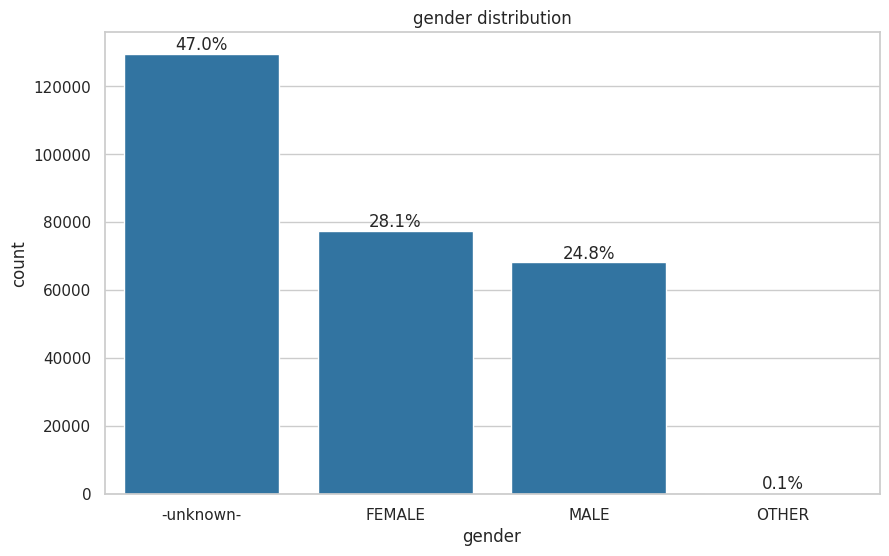

In [19]:
gender_counts = df_all['gender'].value_counts()
total_count = len(df_all)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='gender', order=gender_counts.index)
plt.title('gender distribution')
# 添加標籤
for index, value in enumerate(gender_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)


## Age
1. 資料大多集中在30歲左右
2. 有許多不合理的值(>100)(>2000)，需要另外處理

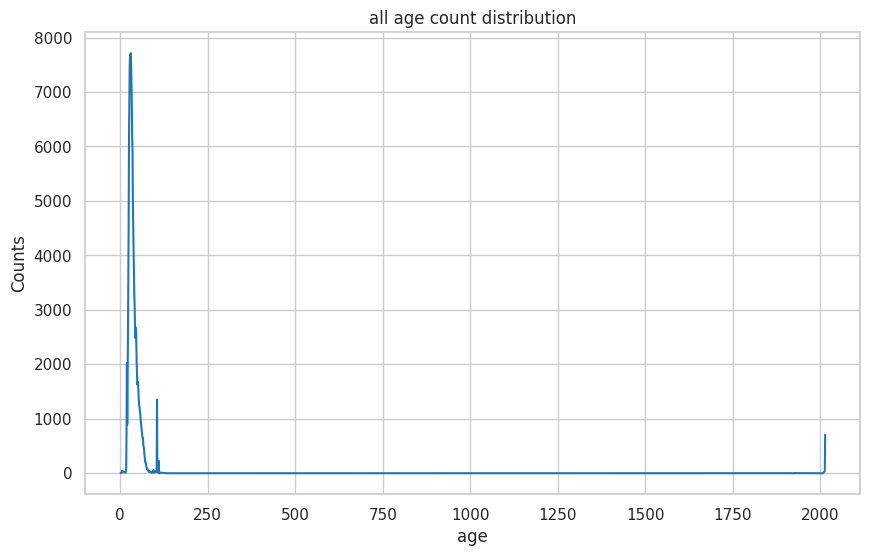

In [20]:
age_counts = df_all.age.value_counts().sort_index()

# 畫折線圖
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_counts.index, y=age_counts.values)
plt.ylabel('Counts')
plt.title('all age count distribution')

plt.show()

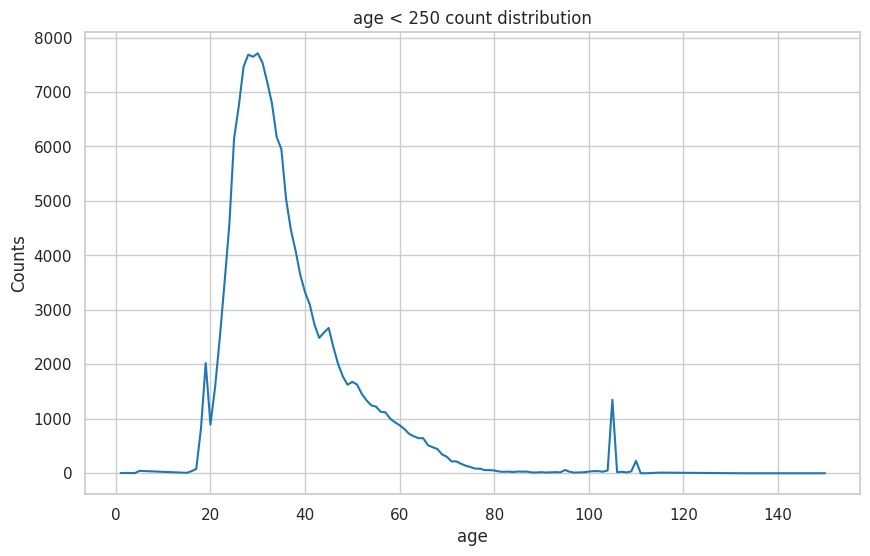

In [21]:
age_counts = df_all.age.value_counts().sort_index()
age_counts_250 = age_counts[age_counts.index<250]
# 畫折線圖
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_counts_250.index, y=age_counts_250.values)
plt.ylabel('Counts')
plt.title('age < 250 count distribution')

plt.show()

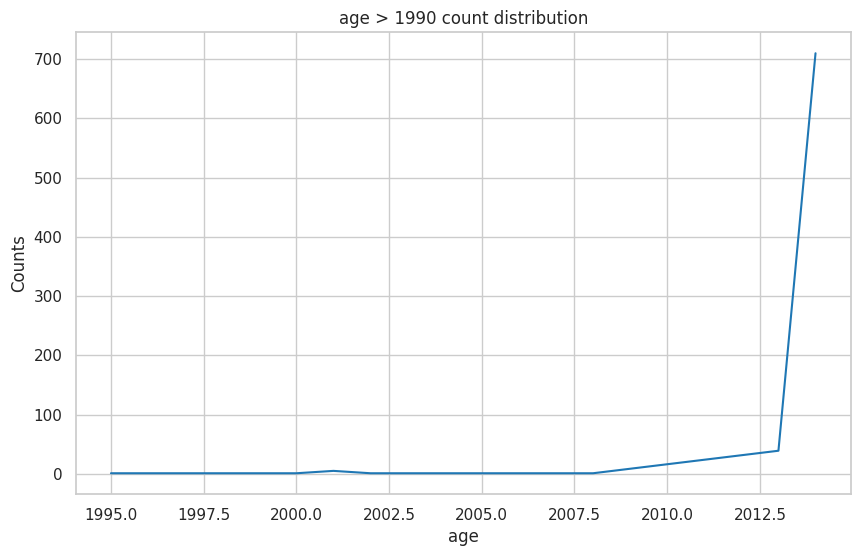

In [22]:
age_counts = df_all.age.value_counts().sort_index()
age_counts_1990 = age_counts[age_counts.index>1990]
# 畫折線圖
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_counts_1990.index, y=age_counts_1990.values)
plt.ylabel('Counts')
plt.title('age > 1990 count distribution')

plt.show()

## signup method
1. basic 佔7成
2. weibo 數量極少

signup_method
basic       198222
facebook     74864
google        2438
weibo           23
Name: count, dtype: int64


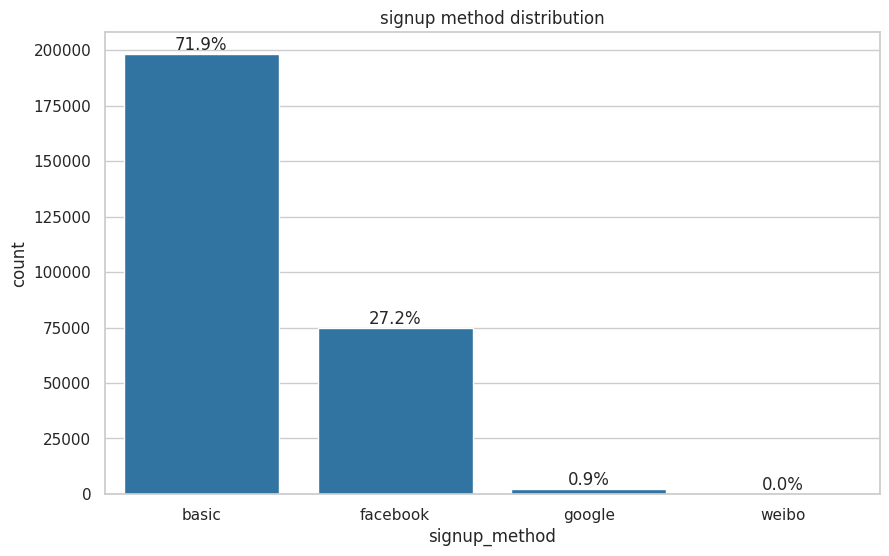

In [23]:
signup_method_counts = df_all['signup_method'].value_counts()
total_count = len(df_all)


print(signup_method_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='signup_method', order=signup_method_counts.index)
plt.title('signup method distribution')
# 添加標籤a
for index, value in enumerate(signup_method_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)


## signup flow
1. 可能是註冊流程編號
2. 大多類型為 1
3. 有許多類別基數很低，可能需另外處理

signup_flow
0     206092
1       1047
2       6881
3       8822
4          1
5         36
6        301
8        315
10         2
12     11244
14         4
15        10
16        11
20        14
21       197
23      6408
24      4328
25     29834
Name: count, dtype: int64


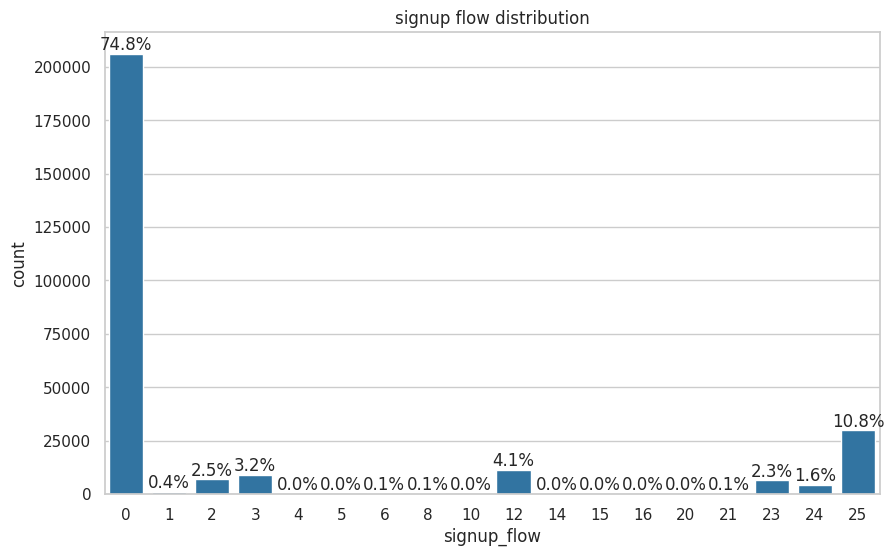

In [25]:
signup_flow_counts = df_all['signup_flow'].value_counts().sort_index()
total_count = len(df_all)


print(signup_flow_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='signup_flow', order=signup_flow_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(signup_flow_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

## language
1. 英文的比例會很高，可能是因為資料來源地是美國
2. 可能需要考慮排除英文或其他處理方法

language
-unknown-         1
ca                6
cs               49
da               75
de              977
el               30
en           265538
es             1174
fi               20
fr             1508
hr                2
hu               25
id               23
is                5
it              633
ja              345
ko             1116
nl              134
no               51
pl               75
pt              322
ru              508
sv              176
th               28
tr               92
zh             2634
Name: count, dtype: int64


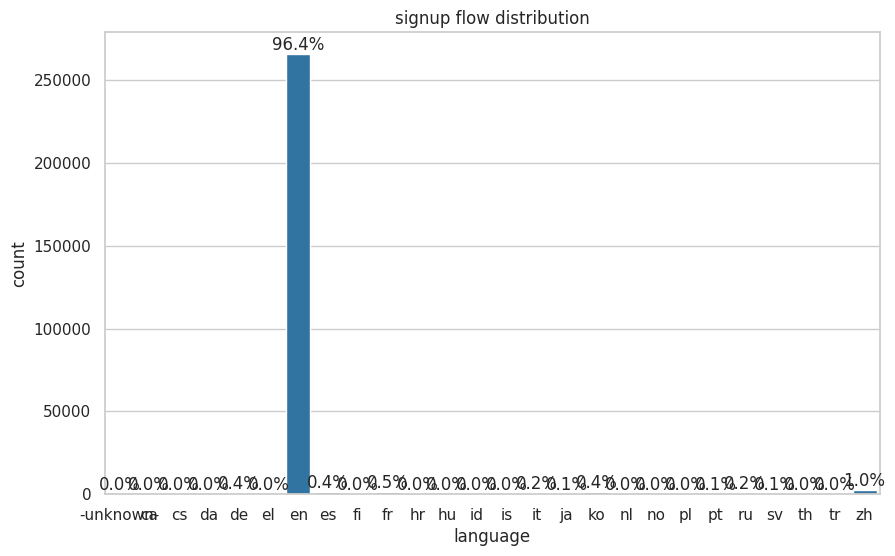

In [26]:
language_counts = df_all['language'].value_counts().sort_index()
total_count = len(df_all)


print(language_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='language', order=language_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(language_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

language
-unknown-       1
ca              6
cs             49
da             75
de            977
el             30
en              0
es           1174
fi             20
fr           1508
hr              2
hu             25
id             23
is              5
it            633
ja            345
ko           1116
nl            134
no             51
pl             75
pt            322
ru            508
sv            176
th             28
tr             92
zh           2634
Name: count, dtype: int64


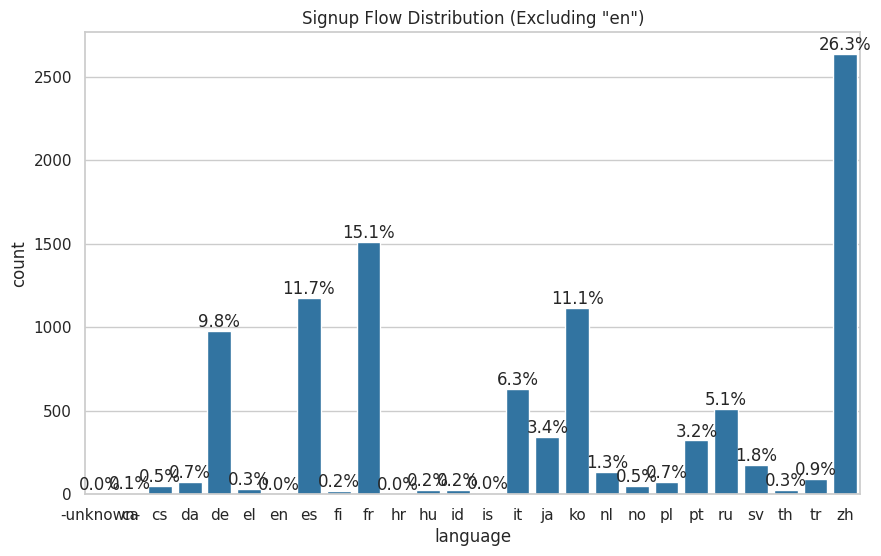

In [27]:
# 刪掉英文重做視覺化

# 篩選掉 'en' 的資料
df_filtered = df_all[df_all['language'] != 'en']

# 計算篩選後語言的分佈
language_counts = df_filtered['language'].value_counts().sort_index()
total_count = len(df_filtered)


print(language_counts)


plt.figure(figsize=(10,6))
sns.countplot(data=df_filtered, x='language', order=language_counts.index)
plt.title('Signup Flow Distribution (Excluding "en")')

# 添加標籤
for index, value in enumerate(language_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)


## affiliate_channel
1. 可能代表進入網站的方法
2. 比例較低的資料可能可以處理

affiliate_channel
api                8167
content            4118
direct           181571
other              9547
remarketing        1268
sem-brand         36439
sem-non-brand     20075
seo               14362
Name: count, dtype: int64


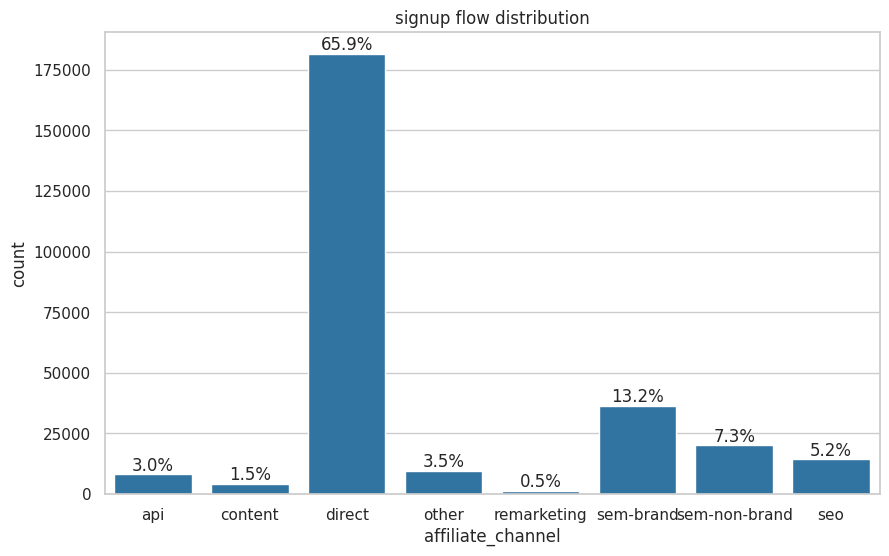

In [28]:
affiliate_channel_counts = df_all['affiliate_channel'].value_counts().sort_index()
total_count = len(df_all)


print(affiliate_channel_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='affiliate_channel', order=affiliate_channel_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(affiliate_channel_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

## affiliate_provider_counts
1. 類別數量不平衡，只有三種較高

affiliate_provider
baidu                      32
bing                     3719
craigslist               3475
daum                        3
direct                 181270
email-marketing           270
facebook                 3996
facebook-open-graph       566
google                  65956
gsp                       455
meetup                    358
naver                      66
other                   13036
padmapper                 836
vast                      830
wayn                        8
yahoo                     653
yandex                     18
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'baidu'),
  Text(1, 0, 'bing'),
  Text(2, 0, 'craigslist'),
  Text(3, 0, 'daum'),
  Text(4, 0, 'direct'),
  Text(5, 0, 'email-marketing'),
  Text(6, 0, 'facebook'),
  Text(7, 0, 'facebook-open-graph'),
  Text(8, 0, 'google'),
  Text(9, 0, 'gsp'),
  Text(10, 0, 'meetup'),
  Text(11, 0, 'naver'),
  Text(12, 0, 'other'),
  Text(13, 0, 'padmapper'),
  Text(14, 0, 'vast'),
  Text(15, 0, 'wayn'),
  Text(16, 0, 'yahoo'),
  Text(17, 0, 'yandex')])

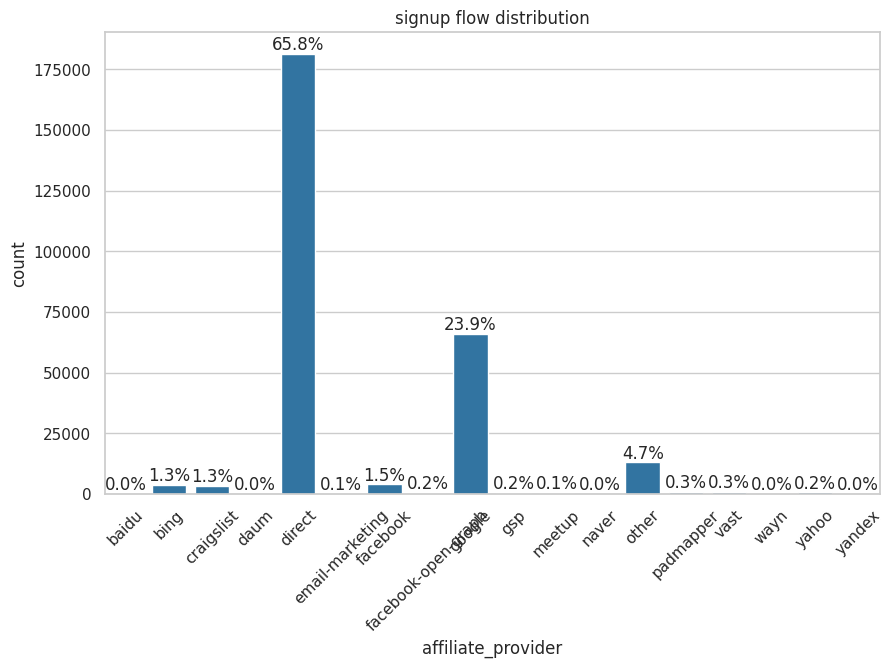

In [29]:
affiliate_provider_counts = df_all['affiliate_provider'].value_counts().sort_index()
total_count = len(df_all)


print(affiliate_provider_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='affiliate_provider', order=affiliate_provider_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(affiliate_provider_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

# 旋轉X軸的字標籤
plt.xticks(rotation=45)

## first_affiliate_tracked
1. 只有3類特別多，剩下的類別可能可以合併

first_affiliate_tracked
linked            62064
local ops            69
marketing           281
omg               54859
product            2353
tracked-other      6655
untracked        143181
Name: count, dtype: int64


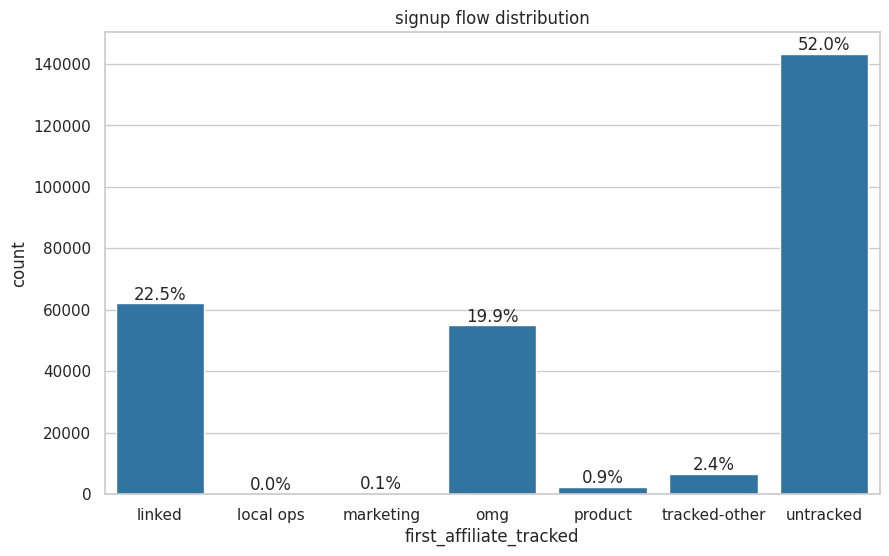

In [30]:

first_affiliate_tracked_counts = df_all['first_affiliate_tracked'].value_counts().sort_index()
total_count = len(df_all)


print(first_affiliate_tracked_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='first_affiliate_tracked', order=first_affiliate_tracked_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(first_affiliate_tracked_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

## signup_app
1. web 比例最高

signup_app
Android     10519
Moweb       10517
Web        219918
iOS         34593
Name: count, dtype: int64


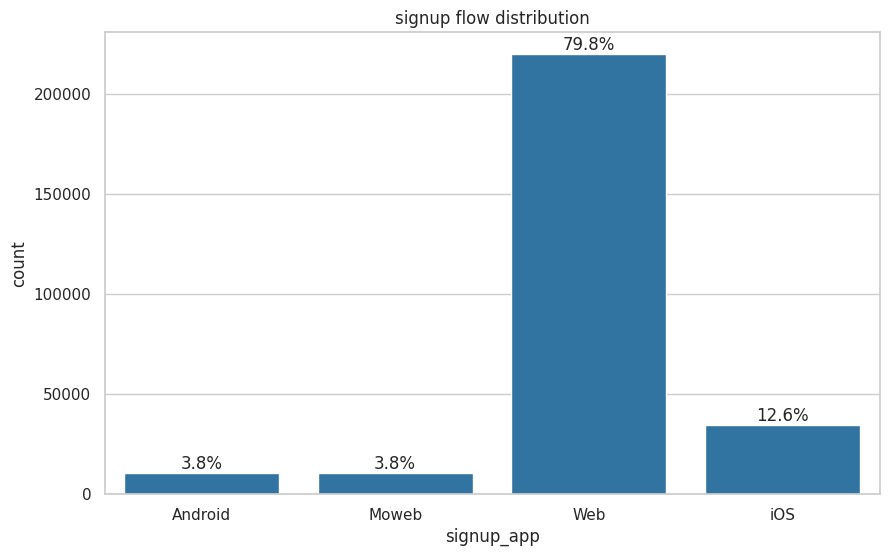

In [31]:
signup_app_counts = df_all['signup_app'].value_counts().sort_index()
total_count = len(df_all)


print(signup_app_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='signup_app', order=signup_app_counts.index)
plt.title('signup flow distribution')

# 添加標籤
for index, value in enumerate(signup_app_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

## first_device_type

first_device_type
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
Mac Desktop           106328
Other/Unknown          11167
SmartPhone (Other)       191
Windows Desktop        86948
iPad                   18036
iPhone                 39814
Name: count, dtype: int64


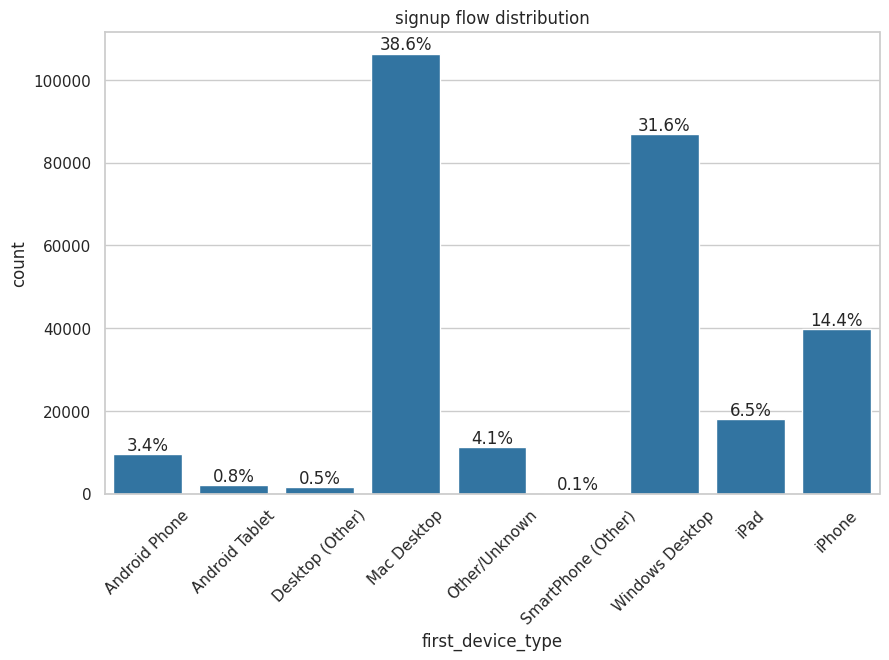

In [32]:

first_device_type_counts = df_all['first_device_type'].value_counts().sort_index()
total_count = len(df_all)


print(first_device_type_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='first_device_type', order=first_device_type_counts.index)
plt.title('signup flow distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(first_device_type_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

## first_browser
1. 種類很多，但只有其中幾類占比夠高

first_browser
-unknown-               44394
AOL Explorer              254
Android Browser          1577
Apple Mail                 45
Arora                       1
Avant Browser               4
BlackBerry Browser         89
Camino                      9
Chrome                  78671
Chrome Mobile            3186
Chromium                   83
CometBird                  12
Comodo Dragon               2
Conkeror                    1
CoolNovo                    6
Crazy Browser               2
Epic                        1
Firefox                 38665
Flock                       2
Google Earth                1
Googlebot                   1
IBrowse                     1
IE                      24744
IE Mobile                 118
IceDragon                   1
IceWeasel                  14
Iron                       24
Kindle Browser              1
Maxthon                    60
Mobile Firefox             64
Mobile Safari           29636
Mozilla                     3
NetNewsWire               

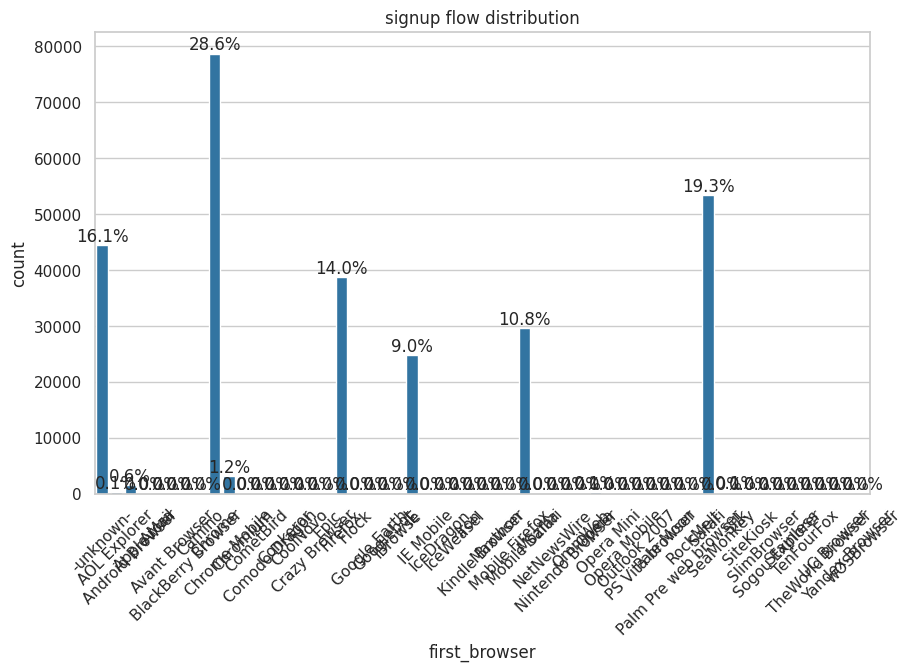

In [33]:
first_browser_counts = df_all['first_browser'].value_counts().sort_index()
total_count = len(df_all)


print(first_browser_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='first_browser', order=first_browser_counts.index)
plt.title('signup flow distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(first_browser_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

## 時間資料處理及視覺化

1. 年分 12 . 13 . 14 有較多資料，並有隨年份遞增的趨勢
2. 月份通常在7.8.9月有較多的資料，可以考慮把月份也變成一個有序類別變數

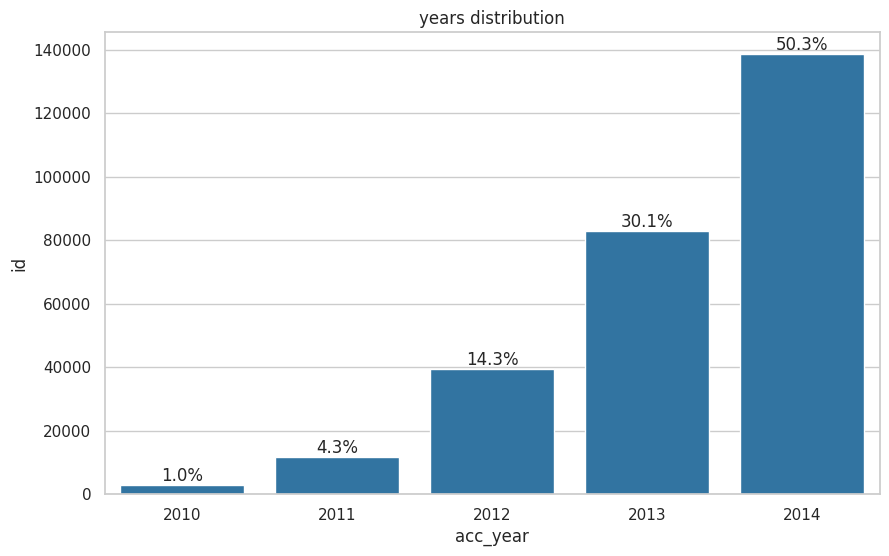

In [34]:
#轉格式
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

df_all['acc_year'] = df_all['date_account_created'].dt.year
df_year = df_all.groupby('acc_year').count()
#設定有序類別
years = [2010,2011,2012,2013,2014]
years_order = pd.api.types.CategoricalDtype(ordered=True,categories=years)
df_year.reset_index(inplace = True)
df_year.acc_year = df_year.acc_year.astype(years_order)

total_count = len(df_all)

plt.figure(figsize=(10,6))
sns.barplot(data=df_year,x='acc_year',y= 'id')
plt.title('years distribution')
# 旋轉X軸的字標籤
# plt.xticks(rotation=45)
# 添加標籤
for i in range(df_year.shape[0]):
    count = df_year.iloc[i]['id']
    percentage = f"{(count / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(i, count + 0.1, percentage, ha='center', va='bottom', fontsize=12)

<ipython-input-35-eec57a239035>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_14['month_14'] = df_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_14
01-2014    11111
02-2014     9967
03-2014    12058
04-2014    12689
05-2014    14895
06-2014    15746
07-2014    21696
08-2014    21626
09-2014    18774
Name: count, dtype: int64


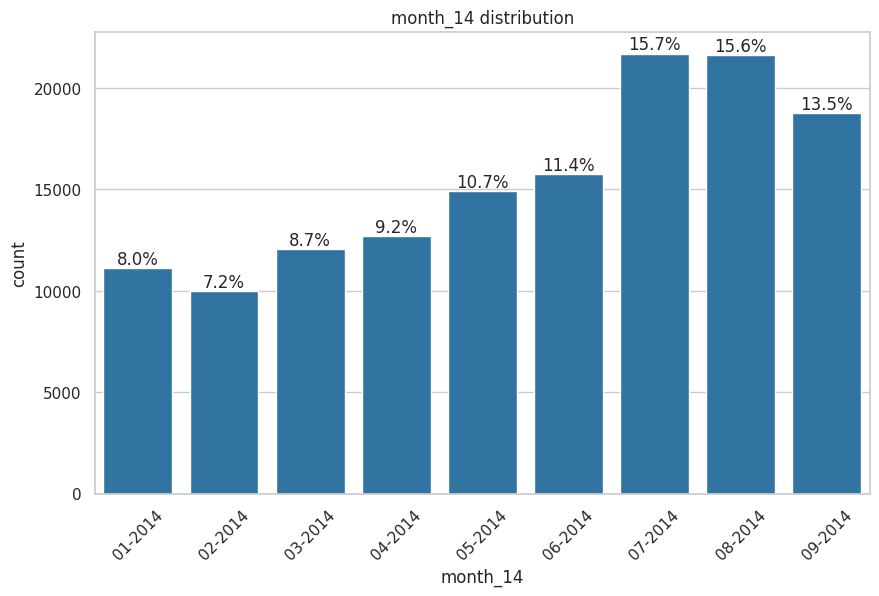

In [35]:
df_14 = df_all[df_all.date_account_created.dt.year==2014]
df_14['month_14'] = df_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_14_counts = df_14['month_14'].value_counts().sort_index()
total_count = len(df_14)


print(month_14_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_14,x='month_14', order=month_14_counts.index)
plt.title('month_14 distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(month_14_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

<ipython-input-36-9cfe90514855>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_13['month_13'] = df_13['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_13
01-2013    4418
02-2013    4362
03-2013    5421
04-2013    5855
05-2013    6721
06-2013    6765
07-2013    7950
08-2013    8369
09-2013    9125
10-2013    7862
11-2013    7751
12-2013    8361
Name: count, dtype: int64


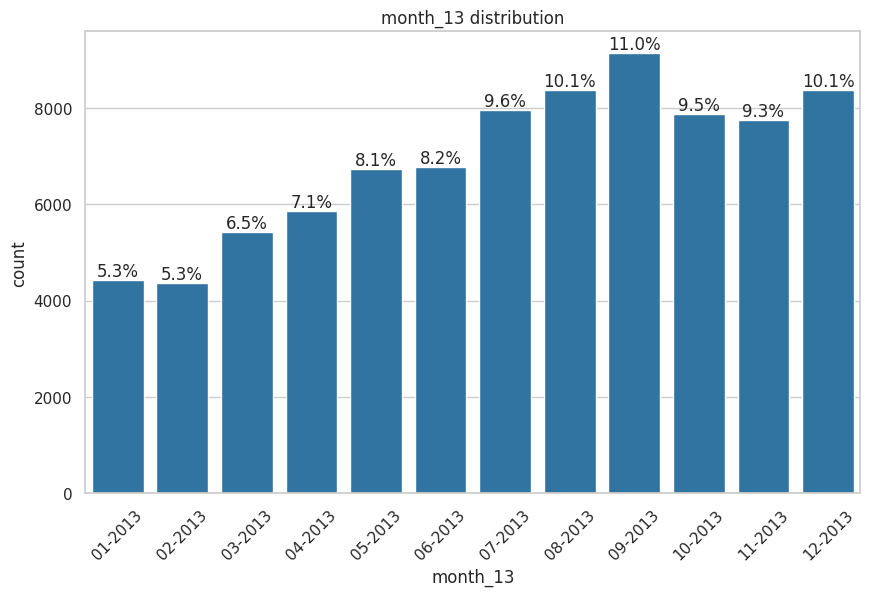

In [36]:
df_13 = df_all[df_all.date_account_created.dt.year==2013]
df_13['month_13'] = df_13['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_13_counts = df_13['month_13'].value_counts().sort_index()
total_count = len(df_13)


print(month_13_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_13,x='month_13', order=month_13_counts.index)
plt.title('month_13 distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(month_13_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

<ipython-input-37-b861ed650375>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['month_12'] = df_12['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_12
01-2012    1589
02-2012    1789
03-2012    2192
04-2012    2589
05-2012    3325
06-2012    3867
07-2012    4582
08-2012    4476
09-2012    4035
10-2012    3828
11-2012    3706
12-2012    3484
Name: count, dtype: int64


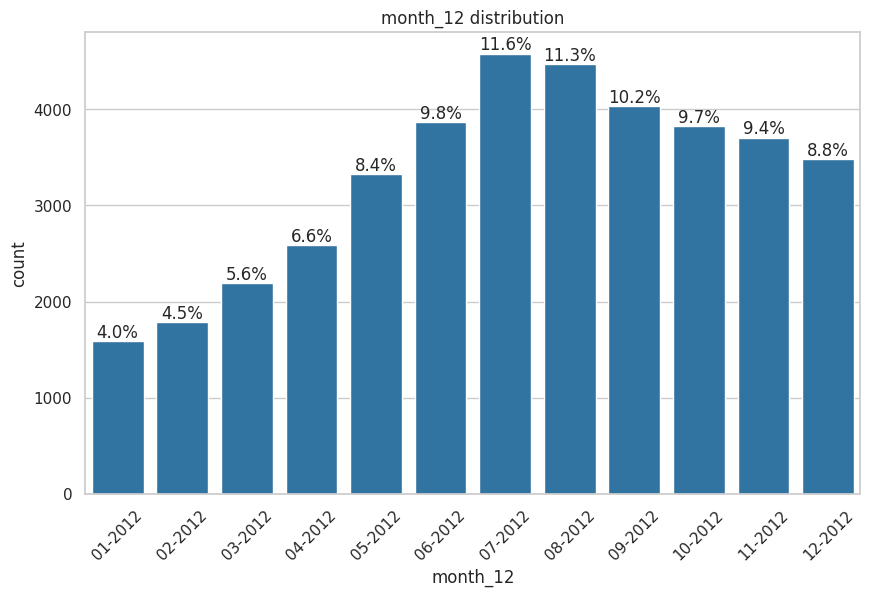

In [37]:
df_12 = df_all[df_all.date_account_created.dt.year==2012]
df_12['month_12'] = df_12['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_12_counts = df_12['month_12'].value_counts().sort_index()
total_count = len(df_12)


print(month_12_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_12,x='month_12', order=month_12_counts.index)
plt.title('month_12 distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(month_12_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

# label distribution

country_destination
NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: count, dtype: int64


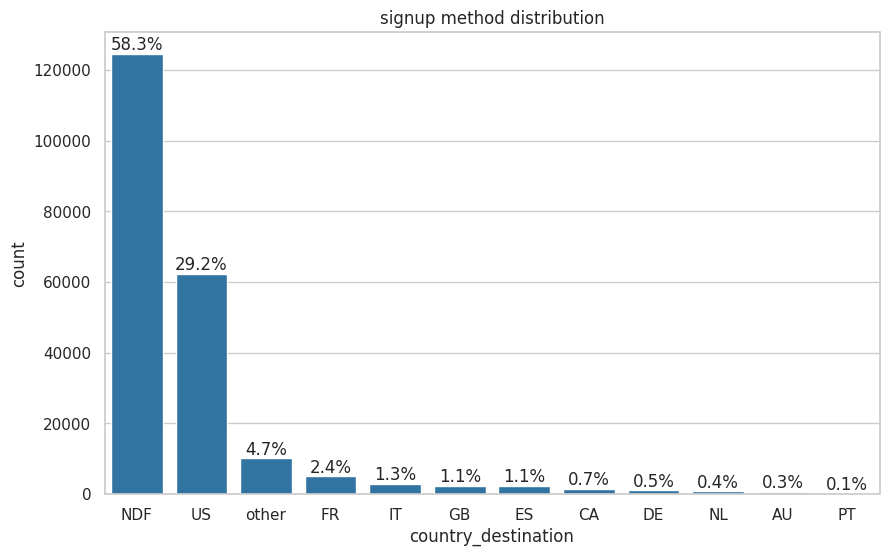

In [38]:
#label distribution
country_destination_counts = df_train['country_destination'].value_counts()
total_count = len(df_train)


print(country_destination_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_train,x='country_destination', order=country_destination_counts.index)
plt.title('signup method distribution')
# 添加標籤a
for index, value in enumerate(country_destination_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)

# 相關性分析
1. 因為無序類別變數很多，全部使用one hot encoding後會使得維度很大，相關係數圖複雜

## 加入target做相關係數圖

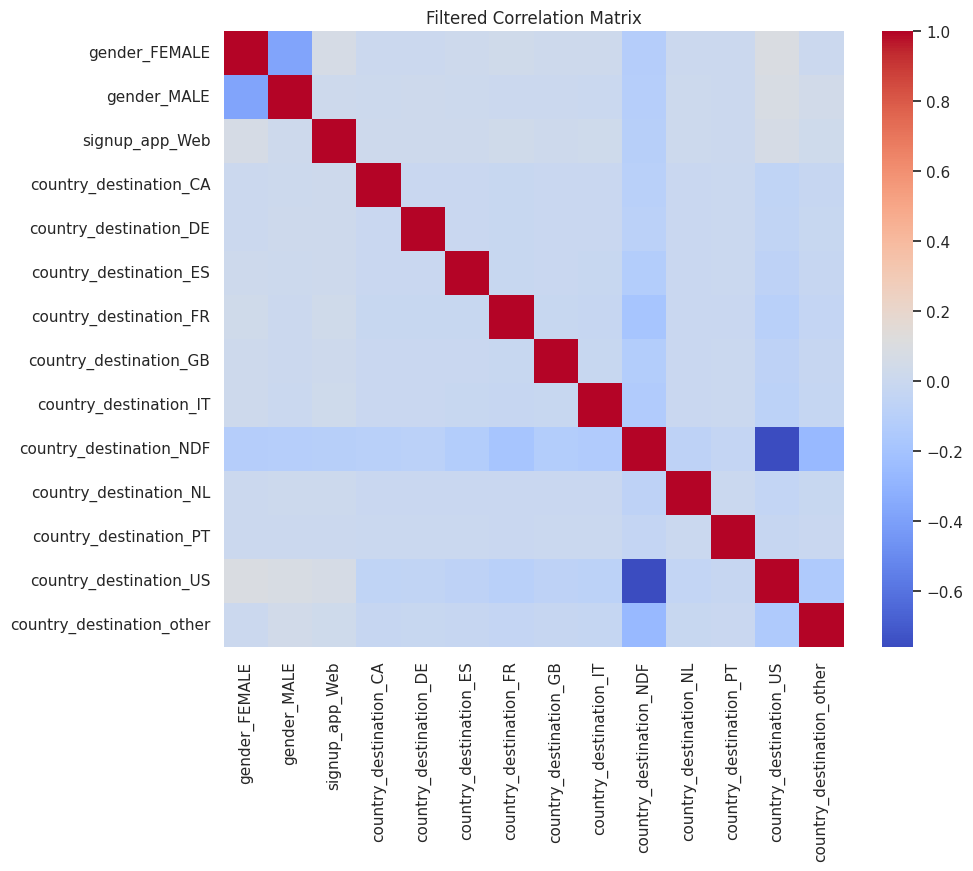

In [40]:
feature = [
    'gender',
    'age',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'acc_year'
]

order_category = ['acc_year']
non_order_category = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser' ,
    'country_destination'
]

df_selected = df_all.loc[:df_train.shape[0],feature].copy()
df_selected['country_destination'] = df_train['country_destination']
# Step 1: 處理 order_category (Label Encoding)
label_encoder = LabelEncoder()
for col in order_category:
    df_selected[col] = label_encoder.fit_transform(df_selected[col])

# Step 2: 處理 non_order_category (One-Hot Encoding)
df_selected = pd.get_dummies(df_selected, columns=non_order_category, drop_first=True)

# Step 3: 計算相關性矩陣
correlation_matrix = df_selected.corr()


# 選擇所有以 country_destination_ 開頭的變數
target_columns = [col for col in correlation_matrix.columns if col.startswith('country_destination_')]

# 計算這些目標變數與其他變數的最大相關性
target_correlation = correlation_matrix[target_columns].abs().max(axis=1)

# 設定相關性閾值
threshold = 0.1

# 篩選相關性大於閾值的特徵
filtered_features = target_correlation[target_correlation > threshold].index

# 過濾矩陣
filtered_corr_matrix = correlation_matrix.loc[filtered_features, filtered_features]

# 可視化
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=False, cmap="coolwarm", fmt='.2f')
plt.title("Filtered Correlation Matrix")
plt.show()

## 全部類別都使用lable encoding編碼

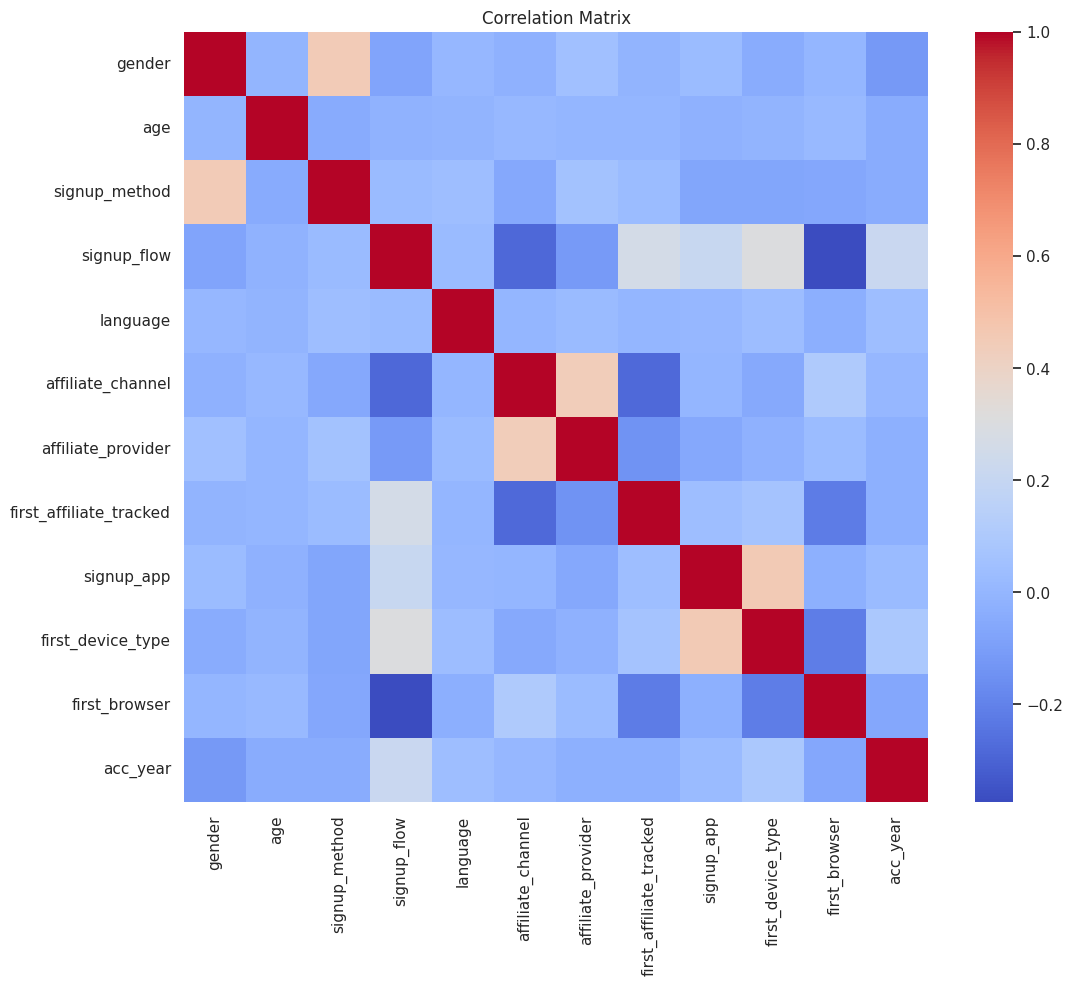

In [41]:
feature = [
    'gender',
    'age',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'acc_year'
]

category = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser' ,
    'acc_year'
]

# 選擇要分析的特徵
df_selected = df_all[feature].copy()

# Step 1: 處理 order_category (Label Encoding)
label_encoder = LabelEncoder()
for col in category:
    df_selected[col] = label_encoder.fit_transform(df_selected[col])


# Step 3: 計算相關性矩陣
correlation_matrix = df_selected.corr()

# 可視化相關性矩陣（選擇性）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

## 共線性分析
1. 幾乎沒有共線性


In [42]:

# 為避免截距項的影響，添加常數列
X = add_constant(df_selected)
X.dropna(inplace=True)

# 計算每個變數的VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 顯示VIF結果
print(vif_data)


                   Variable        VIF
0                     const  55.188628
1                    gender   1.077782
2                       age   1.005722
3             signup_method   1.096034
4               signup_flow   1.389891
5                  language   1.005533
6         affiliate_channel   1.365565
7        affiliate_provider   1.217330
8   first_affiliate_tracked   1.130745
9                signup_app   1.257209
10        first_device_type   1.341196
11            first_browser   1.180044
12                 acc_year   1.057785


# P value

In [43]:
import statsmodels.api as sm

# 複製一份資料
df_clean = df_train.copy()

# 刪除有缺失值的行
df_clean = df_clean.dropna()

feature = [
    'gender',
    'age',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser'
]

category = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser' ,
    'country_destination'
]

label_encoder = LabelEncoder()
for col in category:
    df_clean[col] = label_encoder.fit_transform(df_clean[col])

X = df_clean[feature]
y = df_clean['country_destination']

# 添加常數列，因為statsmodels需要常數項
X = sm.add_constant(X)

# 擬合線性回歸模型
model = sm.OLS(y, X).fit()

# 顯示模型摘要，裡面有P-value
print(model.summary())


<ipython-input-43-261d657da484>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = label_encoder.fit_transform(df_clean[col])
<ipython-input-43-261d657da484>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = label_encoder.fit_transform(df_clean[col])
<ipython-input-43-261d657da484>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

                             OLS Regression Results                            
Dep. Variable:     country_destination   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     20.64
Date:                 Thu, 20 Mar 2025   Prob (F-statistic):           2.13e-42
Time:                         01:38:01   Log-Likelihood:            -1.4850e+05
No. Observations:                68171   AIC:                         2.970e+05
Df Residuals:                    68159   BIC:                         2.971e+05
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

# data processing

1. miss value
 * age
 * first_affiliate_tracked

2.age 有 outliner, K-means 偵測

3.language 只有test資料有一筆 unknown

1. 評斷標準為dcg_score
2. 比較個特徵工程方法後模型分數
3. 參數調整
4. catboost 做完做xgboost
5. Ensemble Learning
6. Parameter Search : random search ,  grid search, Bayesian optimiaztion


# 特徵工程的更多處理

1. 0.8239
2. 0.8252
3. 0.8256 (特徵工程完畢)

---
# 新增
1. first browser 分類
2. age 缺失值改用KNN
3. 年齡填到出生年的轉換
---
(最後做)處理session的資料並運用

In [44]:
df_train = train.copy()
df_test = test.copy()

In [45]:
labels = df_train['country_destination']
df_train = df_train.drop(['country_destination'], axis=1)
dfWork = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [46]:
dfWork = dfWork.drop(['date_first_booking'], axis=1)

In [47]:
# 日期特徵工程
#date account creat
dac = np.vstack(dfWork.date_account_created.astype(str)
                .apply(lambda x: list(map(int, x.split('-')))).values)

dfWork['dac_year'] = dac[:, 0]
dfWork['dac_month'] = dac[:, 1]


#timestamp_first_active
tfa = np.vstack(dfWork.timestamp_first_active.astype(str).apply(lambda x: list(map(int,[x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)

dfWork['tfa_year'] = dac[:, 0]
dfWork['tfa_month'] = dac[:, 1]

In [48]:
def group_browsers(df, verbose=True):
    """Replaces browser names with their respective category based on predefined categories."""
    browser_categories = {
        'Mobile Browsers': [
            'Mobile Safari', 'Chrome Mobile', 'Android Browser', 'Opera Mini', 'BlackBerry Browser',
            'Mobile Firefox', 'IE Mobile', 'Opera Mobile', 'Kindle Browser', 'Palm Pre web browser',
            'PS Vita browser', 'wOSBrowser'
        ],
        'Desktop Browsers': [
            'Chrome', 'Safari', 'Firefox', 'IE', 'Opera', 'Chromium', 'Maxthon', 'RockMelt', 'Yandex.Browser',
            'Camino', 'Pale Moon', 'TenFourFox', 'SeaMonkey', 'Avant Browser', 'CoolNovo', 'TheWorld Browser',
            'Mozilla', 'SlimBrowser', 'CometBird', 'Stainless', 'Comodo Dragon', 'Iron', 'IceWeasel', 'Sogou Explorer',
            'SiteKiosk','AOL Explorer', 'Silk'
        ],
        'Email Clients': [
            'Apple Mail', 'NetNewsWire'
        ],
        'Bots and Crawlers': [
            'Googlebot'
        ]
    }

    for category, browsers in browser_categories.items():
        df.first_browser.replace(to_replace=browsers, value=category, inplace=True)

    if verbose:
        print("Browsers categorized into: ", list(browser_categories.keys()))

group_browsers(dfWork)

<ipython-input-48-300fe5cf0181>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.first_browser.replace(to_replace=browsers, value=category, inplace=True)


Browsers categorized into:  ['Mobile Browsers', 'Desktop Browsers', 'Email Clients', 'Bots and Crawlers']


In [51]:
#age 缺失值處理
# Apply KNN Imputation without One-Hot Encoding
def knn_impute_without_onehot(df, numeric_cols, n_neighbors=5):
    """
    Impute missing values using KNN for numeric columns.
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        numeric_cols (list): List of numeric column names to impute.
        n_neighbors (int): Number of neighbors for KNN Imputer.
    Returns:
        pd.DataFrame: DataFrame with imputed values.
    """
    # Apply KNN imputation to numeric columns only
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_numeric_data = knn_imputer.fit_transform(df[numeric_cols])

    # Replace the imputed numeric values back into the original DataFrame
    for idx, col in enumerate(numeric_cols):
        df[col] = imputed_numeric_data[:, idx]

    return df




In [52]:
knn_impute_without_onehot(dfWork,['age'])

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,tfa_year,tfa_month
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,47.14531,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Desktop Browsers,2010,6,2010,6
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.00000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Desktop Browsers,2011,5,2011,5
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.00000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,Desktop Browsers,2010,9,2010,9
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.00000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Desktop Browsers,2011,12,2011,12
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.00000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Desktop Browsers,2010,9,2010,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,cv0na2lf5a,2014-09-30,20140930235232,-unknown-,31.00000,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Desktop Browsers,2014,9,2014,9
275543,zp8xfonng8,2014-09-30,20140930235306,-unknown-,47.14531,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-,2014,9,2014,9
275544,fa6260ziny,2014-09-30,20140930235408,-unknown-,47.14531,basic,0,de,direct,direct,linked,Web,Windows Desktop,Desktop Browsers,2014,9,2014,9
275545,87k0fy4ugm,2014-09-30,20140930235430,-unknown-,47.14531,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Desktop Browsers,2014,9,2014,9


In [53]:
#age 可能填到出生年轉換成年齡

def calc_age_from_bdate(df, LB=1900, UB=2000):
    """
    Calculate the age by subtracting the presumed birth year from the account creation year.
    Parameters:
        df (pd.DataFrame): DataFrame containing the 'age' and 'date_account_created' columns.
        LB (int): Lower bound for birth year values to consider valid.
        UB (int): Upper bound for birth year values to consider valid.
    """
    # Ensure 'date_account_created' is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['date_account_created']):
        df['date_account_created'] = pd.to_datetime(df['date_account_created'], errors='coerce')

    # Identify indices where age values represent a plausible birth year
    bdate_index = df[(df['age'] > LB) & (df['age'] < UB)].index

    # Log the number of affected records
    print(f"Operation affected {len(bdate_index):,} records.")

    # Recalculate age using the account creation date
    df.loc[bdate_index, 'age'] = (
        df.loc[bdate_index, 'date_account_created'].dt.year - df.loc[bdate_index, 'age']
    )


calc_age_from_bdate(dfWork)

Operation affected 71 records.


In [54]:
#first_affiliate_tracked

dfWork['first_affiliate_tracked'].fillna('untracked',inplace=True)

<ipython-input-54-243f2ecad7e6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfWork['first_affiliate_tracked'].fillna('untracked',inplace=True)


In [55]:
#age異常處理
#直接用範圍<15 & >=100

dfWork[dfWork['age']<15].age = 30
dfWork[dfWork['age']>=100].age = 30

<ipython-input-55-8dd657c47004>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWork[dfWork['age']<15].age = 30
<ipython-input-55-8dd657c47004>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWork[dfWork['age']>=100].age = 30


In [56]:
# session 資料處理
df_sessions = sessions.copy()

# Define aggregation methods, adding a count for the number of actions
enlist = lambda x: x.to_list()
agg_methods = {
    'secs_elapsed': 'sum',
    'action': enlist,
    'action_type': enlist,
    'action_detail': enlist,
    'device_type': enlist
}

# Add a new column 'action_count' to count the number of actions per user
grouped_sessions = df_sessions.groupby('user_id').agg({
    **agg_methods,
    'action': 'count'  # Count the number of actions
}).rename(columns={'action': 'action_count'})

# Re-aggregate 'action' as a list after counting
grouped_sessions['action'] = df_sessions.groupby('user_id')['action'].apply(enlist)

In [57]:
# Selecting only the required columns from grouped_sessions
grouped_sessions_subset = grouped_sessions[['secs_elapsed', 'action_count']]

# Performing the left join
dfWork = pd.merge(dfWork, grouped_sessions_subset, left_on='id', right_index=True, how='left')



In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Encoding categorical features using OneHotEncoder
categorical_features = ['signup_method', 'language', 'affiliate_channel',
                        'first_device_type', 'first_affiliate_tracked', 'affiliate_provider']
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform categorical features, filling missing values with 'missing'
categorical_encoded = onehot_encoder.fit_transform(dfWork[categorical_features].fillna('missing'))

# Prepare numeric features
numeric_features = ['age', 'signup_flow']
numeric_data = dfWork[numeric_features].values

# Combine numeric and encoded categorical features
X = np.hstack([numeric_data, categorical_encoded])

# Identify rows with missing values in 'secs_elapsed' and 'action_count'
filled_rows = dfWork[dfWork['secs_elapsed'].notna() & dfWork['action_count'].notna()].index
missing_rows = dfWork[dfWork['secs_elapsed'].isna() | dfWork['action_count'].isna()].index

# Create boolean masks to select rows in X
filled_mask = dfWork['secs_elapsed'].notna() & dfWork['action_count'].notna()
missing_mask = dfWork['secs_elapsed'].isna() | dfWork['action_count'].isna()

# Use boolean masks to index X
X_filled = X[filled_mask.values]
X_missing = X[missing_mask.values]

#Train KNN models for secs_elapsed and action_count
knn_secs = KNeighborsRegressor(n_neighbors=5)
knn_action = KNeighborsRegressor(n_neighbors=5)

knn_secs.fit(X_filled, dfWork.loc[filled_mask, 'secs_elapsed'].values)
knn_action.fit(X_filled, dfWork.loc[filled_mask, 'action_count'].values)

# Predict missing values
predicted_secs = knn_secs.predict(X_missing)
predicted_action = knn_action.predict(X_missing)

# Fill missing values in the DataFrame
dfWork.loc[missing_mask, 'secs_elapsed'] = predicted_secs
dfWork.loc[missing_mask, 'action_count'] = predicted_action

In [59]:
dfWork.to_csv('/content/drive/MyDrive/kaggle/data.csv', index=False)

移到另一個colab做訓練

In [60]:
dfWork = dfWork.drop(['id','date_account_created','timestamp_first_active'], axis=1)

In [61]:
#照比例切驗證資料
X=dfWork[:df_train.shape[0]]
X_train, X_val, y_train, y_val = train_test_split(X,labels,test_size=0.2,stratify=labels,random_state=42)

In [62]:
X_train.to_csv('/content/drive/MyDrive/kaggle/X_train.csv', index=True)
X_val.to_csv('/content/drive/MyDrive/kaggle/X_val.csv', index=True)
y_train.to_csv('/content/drive/MyDrive/kaggle/y_train.csv', index=True)
y_val.to_csv('/content/drive/MyDrive/kaggle/y_val.csv', index=True)